# Model epidemiològic SIR
## Sense dinàmiques vitals
Aquest model consisteix en un dividir la població en 3 grups: 

* S -> grup susceptible: població sana susceptible de ser infectada
* I -> grup infectat: població infectada
* R -> grup recuperat: població que ja ha passat la malaltia i ha estat immunitzat

L'evolució de la població segueix per tant aquestes equacions diferencials:

$$
\frac{dS}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I (- \kappa I) \\
\frac{dR}{dt} = \gamma I \\
$$

El contagi és proporcional tant al nombre de població susceptible com al de població infectada, amb constant de proporcionalitat $\beta$. La recuperació és proporcional només a la població infectada amb constant de proporcionalitat $\gamma$. També tenim en compte que la població infectada podria morir, amb mortalitat $\kappa$, si la infecció no fos mortal, només cal fer $\kappa=0$.

Més informació: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
###   MODEL   ###
def SIR(t, y, beta, gamma, kappa=0):
    s, i, r = y
    N = np.sum(y)
    ds = - beta / N * s * i
    di = beta / N * s * i - (gamma + kappa) * i 
    dr = gamma * i
    return (ds, di, dr)

In [3]:
###   Funcions per mostrar els resultats  ###
def get_t_sirm(sol):
    t = sol.t
    s, i, r = sol.y
    N = np.sum(sol.y[:,0])
    m = N - np.sum(sol.y, axis=0)
    return t, s, i, r, m, N
    
def plot_result(sol, ax):
    t, s, i, r, m, N = get_t_sirm(sol)
    
    # fer el grafic
    ax.plot(t, s, label="S")
    ax.plot(t, i, label="I", lw=3, zorder=5)
    ax.plot(t, r, label="R")
    ax.plot(t, m, label="M")

def annotate(sol, beta):
    t, s, i, r, m, N = get_t_sirm(sol)
    
    # fer anotacions
    pct_infectats = (1 - s[-1]/N)*100
    pct_recuperats = r[-1]/N*100
    pct_morts = m[-1]/N*100
    print(
        f"Per beta={beta}:\n"
        f"\tel {pct_infectats:.2f}% de la població ha estat infectat\n"
        f"\tel {pct_recuperats:.2f}% de la població s'ha recuperat\n"
        f"\tel {pct_morts:.2f}% de la població ha mort\n\n"
    )

In [4]:
N = 40_000_000
y0 = (N-1, 1, 0)
t_f = 3300
t = np.linspace(0, t_f, 200)

betas = (0.05, 0.04, 0.03, 0.02)
gamma = 0.01
kappa = 3e-4

solutions = []
for beta in betas:
    sol = solve_ivp(SIR, (0, t_f), y0, t_eval=t, args=(beta, gamma, kappa), method="LSODA")
    print(sol.message)
    solutions.append(sol)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


Per beta=0.05:
	el 99.24% de la població ha estat infectat
	el 96.35% de la població s'ha recuperat
	el 2.89% de la població ha mort


Per beta=0.04:
	el 97.89% de la població ha estat infectat
	el 95.04% de la població s'ha recuperat
	el 2.85% de la població ha mort


Per beta=0.03:
	el 93.72% de la població ha estat infectat
	el 90.99% de la població s'ha recuperat
	el 2.73% de la població ha mort


Per beta=0.02:
	el 78.66% de la població ha estat infectat
	el 76.37% de la població s'ha recuperat
	el 2.29% de la població ha mort




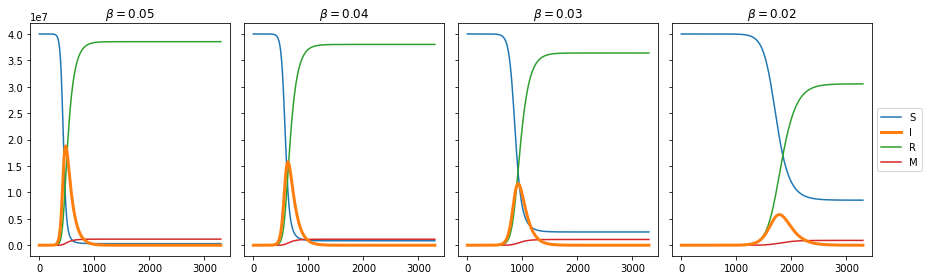

In [5]:
fig, axes = plt.subplots(1,len(betas), figsize=(13,4), sharey=True)
for sol, ax, beta in zip(solutions, axes, betas): 
    plot_result(sol, ax)
    ax.set_title(r"$\beta={}$".format(beta))
    annotate(sol, beta)

    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## Saturació del sistema sanitari
Ara farem una variant del model on els paràmetres dependran del tant per cent de població infectada. Això intenta imitar molt barroerament el fet que al superar la capacitat del sistema sanitari del país, la taxa de recuperació disminuiria i la taxa de mortalitat augmentaria

In [6]:
###   MODEL   ###
def SIR_healtcare_overrun(t, y, beta, gamma, kappa, threshold, gamma_ratio, kappa_ratio):
    s, i, r = y
    N = np.sum(y)
    if (i < threshold):
        k = kappa
        g = gamma
    else:
        k = kappa * kappa_ratio
        g = gamma * gamma_ratio
    ds = - beta / N * s * i
    di = beta / N * s * i - (g + k) * i 
    dr = g * i
    return (ds, di, dr)

In [7]:
# assumim que el sistema sanitari pot atendre 
# a `threshold` pacients
# he triat el numero per tal que els resultats donin joc
threshold = 5_750_000 
# que les recuperacions disminueixen un 30%
gamma_ratio = .7
# i que la mortalitat es multiplica per 5
kappa_ratio = 5
# la resta no estan definits per tal d'utilitzar 
# els valors definits a dalt

solutions_overrun = []
for beta in betas:
    sol = solve_ivp(
        SIR_healtcare_overrun, 
        (0, t_f), 
        y0, 
        t_eval=t, 
        args=(beta, gamma, kappa, threshold, gamma_ratio, kappa_ratio), 
        method="LSODA"
    )
    print(sol.message)
    solutions_overrun.append(sol)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


Per beta=0.05:
	el 99.79% de la població ha estat infectat
	el 85.06% de la població s'ha recuperat
	el 14.73% de la població ha mort


Per beta=0.04:
	el 99.25% de la població ha estat infectat
	el 84.75% de la població s'ha recuperat
	el 14.50% de la població ha mort


Per beta=0.03:
	el 97.07% de la població ha estat infectat
	el 83.56% de la població s'ha recuperat
	el 13.51% de la població ha mort


Per beta=0.02:
	el 82.78% de la població ha estat infectat
	el 76.79% de la població s'ha recuperat
	el 5.99% de la població ha mort




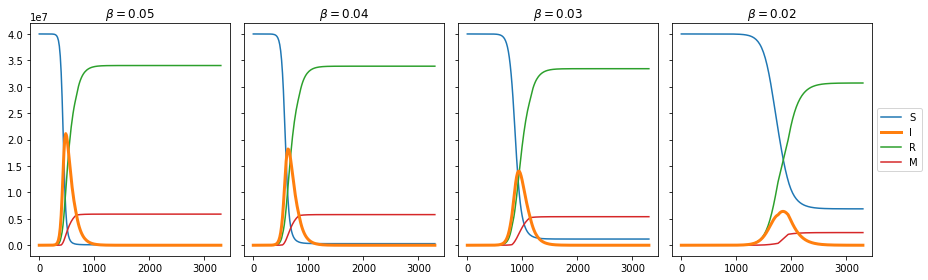

In [8]:
fig, axes = plt.subplots(1,len(betas), figsize=(13,4), sharey=True)
for sol, ax, beta in zip(solutions_overrun, axes, betas): 
    plot_result(sol, ax)
    ax.set_title(r"$\beta={}$".format(beta))
    annotate(sol, beta)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## Comparació

In [9]:
def plot_compare(sol, sol_overrun, ax, threshold):
    t, _, i, _, m, _ = get_t_sirm(sol)
    _, _, i_over, _, m_over, _ = get_t_sirm(sol_overrun)
    
    ax.plot(t, i, label="I", color="C0", zorder=5)
    ax.plot(t, m, label="M", color="C1")
    
    ax.plot(t, i_over, label="I (overrun)", color="C2", ls="--", zorder=5)
    ax.plot(t, m_over, label="M (overrun)", color="C4", ls="--")
    
    m_low = m[-1]
    m_high = m_over[-1]
    m_ratio = m_high / m_low
    if not np.isclose(m_low, m_high):
        ax.vlines(3000, m_low, m_high, "r")
        ax.annotate(
            f"x{m_ratio:.1f} increase\nin mortality", 
            (3000, np.mean((m_low, m_high))), 
            xytext=(2900, 7e6),
            ha="right",
            va="bottom",
            arrowprops = dict(
                arrowstyle = "->",
                connectionstyle = "angle,angleA=270,angleB=180,rad=10"
            )
        )

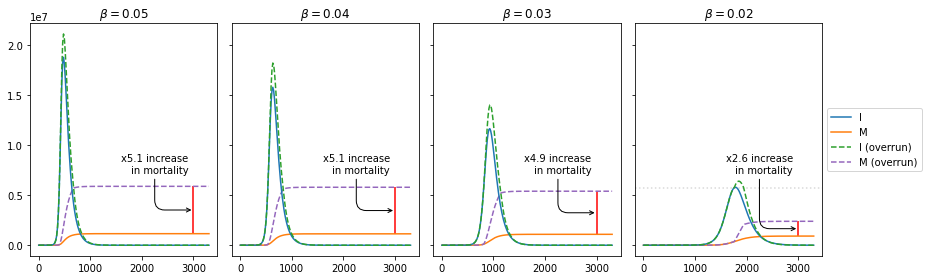

In [10]:
fig, axes = plt.subplots(1,len(betas), figsize=(13,4), sharey=True)
for sol, sol_over, ax, beta in zip(solutions, solutions_overrun, axes, betas): 
    plot_compare(sol, sol_over, ax, threshold)
    ax.set_title(r"$\beta={}$".format(beta))

ax.axhline(threshold, color="gray", ls=":", alpha=.3)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

Com que el fet de saturar el sistema sanitari no només afecta la mortatitat sinó també a la recuperació dels infectats, la mortalitat pot arribar a augmentar més que el factor 5 que ha haugmentat $\kappa$. Això es deu a que la mortalitat la calculem amb la població un cop acabat el brot. Per tant, no només depèn de la constant de mortalitat sinó també del total d'infectats, que també augmenten al saturar el sistema sanitari ja que els pacients triguen més en recuperar-se i en aquest temps extra encara hi ha la possibilitat que contagiin a certa part de la població.

També és rellevant com el fet de passar del _threshold_ tangencialment ja dispara la mortalitat.